# Data wrangling : sparsify, use indices for labels

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sps
%matplotlib widget

In [2]:
envs = pd.read_csv('training_environments.csv', index_col=0)
empo_names = [f'empo_{i}' for i in range(1, 4)]
empo_index_to_label = []

for empo in empo_names:
    empo_index_to_label.append([str(row) for row in envs.drop_duplicates(subset=empo)[empo]])
    
empo_label_to_index = {name : {label : i for i, label in enumerate(labels)} for name, labels in zip(empo_names, empo_index_to_label)}
empo_label_to_index

{'empo_1': {'Free-living': 0, 'Host-associated': 1},
 'empo_2': {'Non-saline': 0, 'Saline': 1, 'Animal': 2, 'Plant': 3},
 'empo_3': {'Water (non-saline)': 0,
  'Soil (non-saline)': 1,
  'Sediment (saline)': 2,
  'Animal surface': 3,
  'Surface (non-saline)': 4,
  'Animal distal gut': 5,
  'Animal corpus': 6,
  'Plant surface': 7,
  'Water (saline)': 8,
  'Animal secretion': 9,
  'Sediment (non-saline)': 10,
  'Plant rhizosphere': 11,
  'Plant corpus': 12,
  'Surface (saline)': 13,
  'Animal proximal gut': 14,
  'Aerosol (non-saline)': 15,
  'Hypersaline (saline)': 16}}

In [3]:
# replace text labels with integers
envs = envs.replace(empo_label_to_index)

In [4]:
import numpy as np

In [5]:
def save_as_sparse(in_filename, out_filename):
    line_count = sum(1 for line in open(in_filename))
    rows = []
    with open(in_filename) as f:
        for i, line in enumerate(f):
            if i == 0:
                continue
            row = [int(x) for x in line.strip().split(',')[1:]]
            row = sps.csr_matrix(row)
            rows.append(row)

            if i % 1000 == 0:
                print(f'Sparsifying {in_filename} [row {i} / {line_count}]\r')
    mat = sps.vstack(rows)
    
    sps.save_npz(out_filename, mat)

In [6]:
from pathlib import Path

def maybe_sparsify(in_filename, out_filename):
    if not Path(out_filename).is_file():
        save_as_sparse(in_filename, out_filename)
        
def get_header_line(csv_file):
    with open(csv_file) as f:
        line = next(f)
        return np.array(line.rstrip().split(',')[1:])
    
maybe_sparsify('training_descriptors.csv', 'training_descriptors_sparse.npz')
maybe_sparsify('challenge_descriptors.csv', 'challenge_descriptors_sparse.npz')

In [13]:
desc_species_names = get_header_line('training_descriptors_header.csv')

desc = sps.load_npz('training_descriptors_sparse.npz')
species = pd.read_csv('bacterial_species.csv', index_col=0)

In [14]:
def sparse_megabytes(a):
    return (a.data.nbytes + a.indptr.nbytes + a.indices.nbytes) / (1024 * 1024)

print(f'In-memory size of desc : {sparse_megabytes(desc):.2f}M')

In-memory size of desc : 496.68M


In [33]:
def to_taxonomy_df(desc, taxon_level):
    taxons = species[taxon_level][desc_species_names]
    columns = taxons.unique()

    taxon_indices, taxon_names = pd.factorize(taxons)
    
    data = np.ones(taxon_indices.shape)
    row_ind = np.arange(taxon_indices.shape[0])
    col_ind = taxon_indices
    
    D = sps.csr_matrix((data, (row_ind, col_ind)))
    
    table = desc @ D
    
    return taxon_names, table

taxon_names = {}
taxons = {}

for taxon_level in species.columns:
    taxon_names[taxon_level], taxons[taxon_level] = to_taxonomy_df(desc, taxon_level)

# Classification

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate

clf_logit = LogisticRegression(random_state=0, n_jobs=-1)
clf_rforest = RandomForestClassifier(random_state=0, n_jobs=-1)

In [58]:
def cross_validate_clf(clf, desc, empo, samples=None, fast=False, n_splits=5):
    samples = samples if samples is not None else desc.shape[0]
    
    # shuffle and truncate data
    idx = np.arange(samples)

    gen = np.random.default_rng(0)
    gen.shuffle(idx)
    idx = idx[:samples]
    
    desc = desc[idx]
    empo = empo[idx]
    
    if fast:
        print('Warning : using fast evaluation, cross-validation turned off.')
        
        train_pcent = 1 - 1 / n_splits
        train_count = int(round(train_pcent * samples))

        desc_train = desc_shuf[:train_count]
        desc_validate = desc_shuf[train_count:]

        empo_train = empo[:train_count]
        empo_validate = empo[train_count:]

        clf.fit(desc_train, empo_train)
        accuracy = clf.score(desc_validate, empo_validate)
        accuracies = np.array([accuracy])
        
        f1 = f1_score(clf.predict(desc_validate), empo_validate, average='weighted')
        f1 = np.array([f1])
        
        return {'test_accuracy' : accuracies, 'test_f1_weighted' : f1}
    else:
        # cross validation
        k_folds = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    
        return cross_validate(clf, desc, empo, cv=k_folds, scoring=['accuracy', 'f1_weighted'], n_jobs=-1)
    
def train_clf(clf, desc, envs, empo):
    clf.fit(desc, envs[empo])

In [175]:
scores = []
features = [(taxon_level, taxons[taxon_level]) for taxon_level in species.columns]
features.append(('desc', desc))

samples=None
for clf_name, clf in [('rforest', clf_rforest), ('logit', clf_logit)]:
    for empo in empo_names:
        for feature_name, feature_vector in features:
            print(clf_name, empo, feature_name)
            
            s = cross_validate_clf(clf, feature_vector, envs[empo], samples=samples)
            s['clf_name'] = clf_name
            s['empo'] = empo
            s['features'] = feature_name
        
            scores.append(s)

scores = pd.DataFrame(scores)

rforest empo_1 taxonomy_0
rforest empo_1 taxonomy_1
rforest empo_1 taxonomy_2
rforest empo_1 taxonomy_3
rforest empo_1 taxonomy_4
rforest empo_1 taxonomy_5
rforest empo_1 taxonomy_6
rforest empo_1 desc
rforest empo_2 taxonomy_0
rforest empo_2 taxonomy_1
rforest empo_2 taxonomy_2
rforest empo_2 taxonomy_3
rforest empo_2 taxonomy_4
rforest empo_2 taxonomy_5
rforest empo_2 taxonomy_6
rforest empo_2 desc
rforest empo_3 taxonomy_0
rforest empo_3 taxonomy_1
rforest empo_3 taxonomy_2
rforest empo_3 taxonomy_3
rforest empo_3 taxonomy_4
rforest empo_3 taxonomy_5
rforest empo_3 taxonomy_6
rforest empo_3 desc
logit empo_1 taxonomy_0
logit empo_1 taxonomy_1


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_1 taxonomy_2


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_1 taxonomy_3


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_1 taxonomy_4


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_1 taxonomy_5


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_1 taxonomy_6


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_1 desc


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_2 taxonomy_0
logit empo_2 taxonomy_1


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_2 taxonomy_2


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_2 taxonomy_3


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_2 taxonomy_4


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_2 taxonomy_5


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_2 taxonomy_6


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_2 desc


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_3 taxonomy_0
logit empo_3 taxonomy_1


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_3 taxonomy_2


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_3 taxonomy_3


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_3 taxonomy_4


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_3 taxonomy_5


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_3 taxonomy_6


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

logit empo_3 desc


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

In [176]:
for k in ['test_accuracy', 'score_time', 'test_f1_weighted', 'fit_time']:
    scores[k + '_median'] = scores[k].apply(lambda x : np.median(x))

In [178]:
scores.to_csv('scores.csv')

In [179]:
cross_validate_clf(clf_logit, taxons['taxonomy_6'], envs['empo_3'])

/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

{'fit_time': array([17.94763088, 17.51905298, 17.47496009, 18.24486899, 16.73412561]),
 'score_time': array([0.0219779 , 0.01962638, 0.03721762, 0.01913238, 0.03646278]),
 'test_accuracy': array([0.85847034, 0.84965452, 0.84965452, 0.85128694, 0.84056244]),
 'test_f1_weighted': array([0.85270044, 0.84387855, 0.84519   , 0.84387834, 0.83496274])}

In [182]:
feature_vector = taxons['taxonomy_6']
n_features = feature_vector.shape[-1]

# D_0 : Domain
# D_1 : ?
# D_2 : Class
# D_3 : Order
# D_4 : Family
# D_5 : ?
# D_6 : ?

clf_logit.fit(feature_vector, envs['empo_1'])

/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(n_jobs=-1, random_state=0)

/tmp/ipykernel_716503/3140312975.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(range(n_features), sorted(np.log10(abs(clf_logit.coef_[0][feature_idx]))))


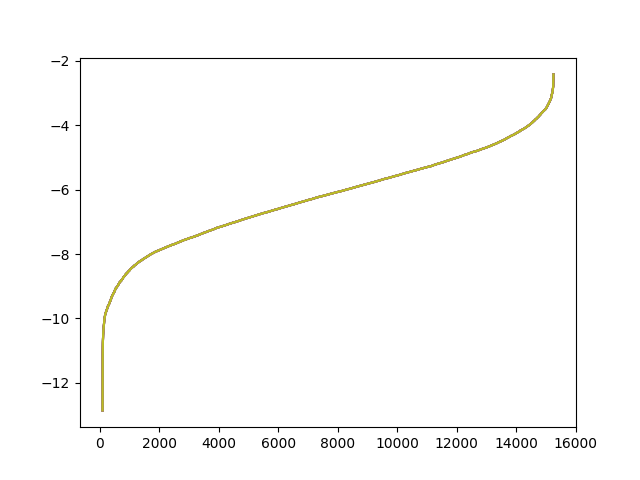

Index(['D_6__Cryptosporangium arvum DSM 44712',
       'D_6__uncultured planctomycete', 'D_6__Acinetobacter sp. OTUC6',
       'D_6__Arthrobacter sp. V-34',
       'D_6__uncultured Rhodocyclaceae bacterium', 'D_6__Burkholderia tuberum',
       'D_6__Lactobacillus kunkeei', 'D_6__Hyphomonadaceae bacterium JC2236',
       'D_6__Acetobacteraceae bacterium B7_1CO2',
       'D_6__Novosphingobium resinovorum', 'D_6__Annona muricata',
       'D_6__uncultured Brevibacillus sp.',
       'D_6__Prevotella corporis DSM 18810 = JCM 8529',
       'D_6__Rhodococcus sp. GBA_111-04', 'D_6__Anaerococcus murdochii',
       'D_6__Scaevola aemula', 'D_6__Frischella perrara',
       'D_6__Corynebacterium riegelii',
       'D_6__uncultured Syntrophaceae bacterium',
       'D_6__Aquimarina sp. KMM 6374', 'D_6__Ectocarpus siliculosus',
       'D_6__Serratia nematodiphila', 'D_6__Simplicispira sp. BDI',
       'D_6__unclassified Pseudomonadales (miscellaneous)',
       'D_6__Enterococcus faecalis', 'D_6__Sphing

In [192]:
feature_idx = np.argsort(clf_logit.coef_[0])
plt.plot(range(n_features), sorted(np.log10(abs(clf_logit.coef_[0][feature_idx]))))
plt.show()

n = 50
print(taxon_names['taxonomy_6'][feature_idx[-50:]])
print(taxon_names['taxonomy_6'][feature_idx[:50]])

# Dimensionality reduction

In [17]:
print(desc)
for taxonomy in list(species):
    print(taxonomy, species[taxonomy].unique().size)

  (0, 11)	95
  (0, 29)	2
  (0, 63)	1
  (0, 187)	7
  (0, 308)	2
  (0, 310)	2
  (0, 335)	22
  (0, 338)	2
  (0, 427)	1
  (0, 478)	26
  (0, 517)	188
  (0, 557)	11
  (0, 570)	1
  (0, 592)	1
  (0, 602)	4
  (0, 687)	2
  (0, 736)	19
  (0, 774)	1
  (0, 788)	1
  (0, 905)	49
  (0, 943)	11
  (0, 949)	1
  (0, 956)	4
  (0, 1132)	247
  (0, 1195)	1
  :	:
  (20982, 84834)	1
  (20982, 85015)	2
  (20982, 85149)	1
  (20982, 85258)	1
  (20982, 85274)	1
  (20982, 85316)	2
  (20982, 85446)	1
  (20982, 94733)	2
  (20982, 96643)	3
  (20982, 96811)	1
  (20982, 97782)	1
  (20982, 98552)	1
  (20982, 105069)	1
  (20982, 105522)	1
  (20982, 105526)	1
  (20982, 105545)	1
  (20982, 105554)	2
  (20982, 105572)	1
  (20982, 105592)	1
  (20982, 105642)	1
  (20982, 105750)	2
  (20982, 105755)	2
  (20982, 105793)	42
  (20982, 105846)	1
  (20982, 105853)	3
taxonomy_0 1
taxonomy_1 67
taxonomy_2 373
taxonomy_3 1120
taxonomy_4 1705
taxonomy_5 4255
taxonomy_6 15295


In [18]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200)
svd.fit(desc)

KeyboardInterrupt: 

In [ ]:
svd.explained_variance_ratio_.sum()

In [ ]:
desc_reduced = svd.transform(desc)

In [ ]:
cross_validate_clf(clf_logit, desc_reduced, envs, 'empo_1')

In [ ]:
cross_validate_clf(clf_logit, desc_reduced, envs, 'empo_2')

In [ ]:
cross_validate_clf(clf_logit, desc_reduced, envs, 'empo_3')

In [ ]:
svd.components_.shape

In [ ]:
plt.ylim(0, 1)
plt.plot(svd.explained_variance_ratio_.cumsum())

In [ ]:
plt.imshow(svd.components_ > 1e-6, aspect='auto')
plt.colorbar()

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
selector = SelectKBest(mutual_info_classif, k=200)

In [ ]:
n=100
selector.fit(desc[:n], envs['empo_1'][:n])

# Challenge prediction

In [ ]:
challenge_desc = sps.load_npz('challenge_descriptors_sparse.npz')

In [ ]:
train_clf(clf_logit, desc, envs, 'empo_1')